In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, random, pickle, json, itertools
import cv2
from IPython.display import SVG

from tensorflow.keras.utils import plot_model#, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tqdm import tqdm

In [2]:
def conv_block(X, k, filters, stage, block, s=2):
    conv_base_name = 'conv_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + "_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k, k), strides=(s, s),
               padding='same', name=conv_base_name + '2a')(X)
    X = BatchNormalization(name=bn_base_name + '2a')(X)
    X = Activation('relu')(X)

    return X
    pass

In [3]:

def basic_model(input_shape,classes):

    X_input = Input(input_shape)

    X = ZeroPadding2D((5,5))(X_input)

    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X)

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')

    return model
    pass

In [4]:
class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [5]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
def load_data():
    print("Loading ship data")
    ships_path = os.path.join('../../data/raw/','shipsnet.json')
    with open(ships_path) as file:
        dataset = json.load(file)

    labels = np.array(dataset["labels"]).astype("float32")

    img_length = 80
    images = np.array(dataset["data"]).astype("uint8")
    images = images.reshape(-1, 3, img_length, img_length).transpose([0, 2, 3, 1])
    images = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in images]
    images = [cv2.resize(img, (48,48)) for img in images]
    images = np.array(images,dtype=np.float32)/255.0
    print("Data loaded")
    return images, labels


In [6]:
(images, labels) = load_data()
images.shape, labels.shape


Loading ship data
Data loaded


((4000, 48, 48, 3), (4000,))

In [8]:
#%%

labels = to_categorical(labels)

#%%

np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

In [9]:

total_count = len(images)
total_count

train = int(0.8*total_count)
test = int(0.2*total_count)

train_images, train_labels = images[:train], labels[:train]
test_images, test_labls = images[-test:], labels[-test:]

train_images.shape, test_images.shape

((3200, 48, 48, 3), (800, 48, 48, 3))

In [10]:
batch_size=16

IGD = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=20,
                         validation_split=0.2)
IGD.fit(train_images)

In [11]:
train_generator = IGD.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    seed = 42,
    shuffle=True,
    subset="training"
    )

val_generator = IGD.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    seed = 42,
    shuffle=True,
    subset="validation",
    )

In [12]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [13]:

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 58, 58, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 29, 29, 16)        448       
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 29, 29, 16)        64        
_________________________________________________________________
conv_2A_branch2a (Conv2D)    (None, 29, 29, 32)        4640      
_________________________________________________________________
bn_2A_branch2a (BatchNormali (None, 29, 29, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 29, 29, 32)        0         
__________

In [14]:
opt = Adam(lr=1e-4)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])

In [15]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_acc',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")


In [16]:
count_labels = train_labels.sum(axis=0)

classTotals = train_labels.sum(axis=0)
classWeight = {}

for i in range(0,len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]
    pass

classWeight


{0: 1.0, 1: 2.9263804}

In [17]:
epochs = 150

history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_generator.n//batch_size,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=val_generator.n//batch_size,
                              callbacks=[checkpoint, logs],
                              class_weight=classWeight,
                              verbose=1)


Epoch 1/150
155/160 [============================>.] - ETA: 0s - loss: 0.8321 - acc: 0.5524
Epoch 00001: val_acc improved from -inf to 0.72969, saving model to model_weights.h5
160/160 [==============================] - 3s 16ms/step - loss: 0.8292 - acc: 0.5574 - val_loss: 0.6488 - val_acc: 0.7297
Epoch 2/150
155/160 [============================>.] - ETA: 0s - loss: 0.6352 - acc: 0.6641
Epoch 00002: val_acc improved from 0.72969 to 0.77500, saving model to model_weights.h5
160/160 [==============================] - 1s 9ms/step - loss: 0.6350 - acc: 0.6629 - val_loss: 0.6080 - val_acc: 0.7750
Epoch 3/150
153/160 [===========================>..] - ETA: 0s - loss: 0.5728 - acc: 0.7161
Epoch 00003: val_acc improved from 0.77500 to 0.84688, saving model to model_weights.h5
160/160 [==============================] - 1s 9ms/step - loss: 0.5722 - acc: 0.7160 - val_loss: 0.4507 - val_acc: 0.8469
Epoch 4/150
152/160 [===========================>..] - ETA: 0s - loss: 0.4890 - acc: 0.7730
Epoch 0

159/160 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9387
Epoch 00030: val_acc did not improve from 0.96562
160/160 [==============================] - 1s 9ms/step - loss: 0.1550 - acc: 0.9391 - val_loss: 0.1383 - val_acc: 0.9344
Epoch 31/150
155/160 [============================>.] - ETA: 0s - loss: 0.1430 - acc: 0.9444
Epoch 00031: val_acc improved from 0.96562 to 0.96875, saving model to model_weights.h5
160/160 [==============================] - 1s 9ms/step - loss: 0.1443 - acc: 0.9426 - val_loss: 0.0758 - val_acc: 0.9688
Epoch 32/150
154/160 [===========================>..] - ETA: 0s - loss: 0.1313 - acc: 0.9476
Epoch 00032: val_acc improved from 0.96875 to 0.97344, saving model to model_weights.h5
160/160 [==============================] - 1s 9ms/step - loss: 0.1285 - acc: 0.9492 - val_loss: 0.0671 - val_acc: 0.9734
Epoch 33/150
155/160 [============================>.] - ETA: 0s - loss: 0.1359 - acc: 0.9444
Epoch 00033: val_acc did not improve from 0.97344
16

154/160 [===========================>..] - ETA: 0s - loss: 0.0809 - acc: 0.9700
Epoch 00060: val_acc did not improve from 0.98906
160/160 [==============================] - 1s 9ms/step - loss: 0.0811 - acc: 0.9695 - val_loss: 0.0712 - val_acc: 0.9734
Epoch 61/150
159/160 [============================>.] - ETA: 0s - loss: 0.0935 - acc: 0.9619
Epoch 00061: val_acc did not improve from 0.98906
160/160 [==============================] - 1s 9ms/step - loss: 0.0929 - acc: 0.9621 - val_loss: 0.0459 - val_acc: 0.9766
Epoch 62/150
159/160 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9662
Epoch 00062: val_acc did not improve from 0.98906
160/160 [==============================] - 1s 9ms/step - loss: 0.0970 - acc: 0.9664 - val_loss: 0.0657 - val_acc: 0.9750
Epoch 63/150
153/160 [===========================>..] - ETA: 0s - loss: 0.0945 - acc: 0.9636
Epoch 00063: val_acc did not improve from 0.98906
160/160 [==============================] - 1s 9ms/step - loss: 0.0924 - acc: 0

159/160 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9772
Epoch 00091: val_acc did not improve from 0.98906
160/160 [==============================] - 1s 9ms/step - loss: 0.0574 - acc: 0.9770 - val_loss: 0.0323 - val_acc: 0.9875
Epoch 92/150
159/160 [============================>.] - ETA: 0s - loss: 0.0712 - acc: 0.9752
Epoch 00092: val_acc improved from 0.98906 to 0.99062, saving model to model_weights.h5
160/160 [==============================] - 1s 9ms/step - loss: 0.0711 - acc: 0.9754 - val_loss: 0.0261 - val_acc: 0.9906
Epoch 93/150
159/160 [============================>.] - ETA: 0s - loss: 0.0587 - acc: 0.9744
Epoch 00093: val_acc did not improve from 0.99062
160/160 [==============================] - 1s 9ms/step - loss: 0.0587 - acc: 0.9746 - val_loss: 0.0318 - val_acc: 0.9906
Epoch 94/150
156/160 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9776
Epoch 00094: val_acc did not improve from 0.99062
160/160 [==============================]

Epoch 122/150
152/160 [===========================>..] - ETA: 0s - loss: 0.0476 - acc: 0.9844
Epoch 00122: val_acc did not improve from 0.99219
160/160 [==============================] - 1s 9ms/step - loss: 0.0468 - acc: 0.9848 - val_loss: 0.0303 - val_acc: 0.9891
Epoch 123/150
153/160 [===========================>..] - ETA: 0s - loss: 0.0427 - acc: 0.9845
Epoch 00123: val_acc did not improve from 0.99219
160/160 [==============================] - 1s 9ms/step - loss: 0.0420 - acc: 0.9848 - val_loss: 0.0394 - val_acc: 0.9891
Epoch 124/150
155/160 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9786
Epoch 00124: val_acc did not improve from 0.99219
160/160 [==============================] - 1s 9ms/step - loss: 0.0543 - acc: 0.9781 - val_loss: 0.0278 - val_acc: 0.9875
Epoch 125/150
155/160 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9823
Epoch 00125: val_acc did not improve from 0.99219
160/160 [==============================] - 1s 9ms/step - loss

In [18]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['acc'],label='Train Accuracy')
    ax[1].plot(history.history['val_acc'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass


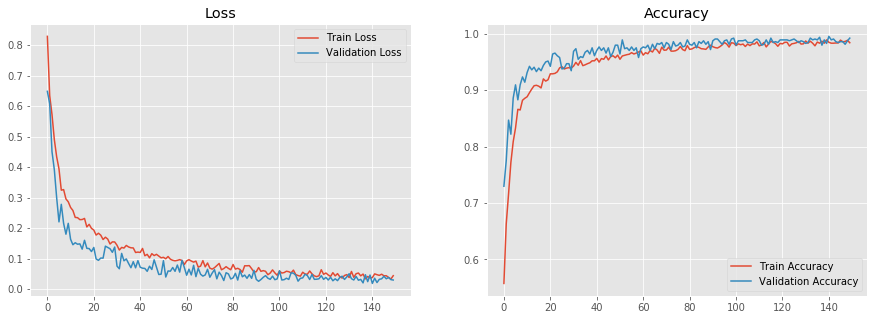

In [19]:
show_final_history(history)



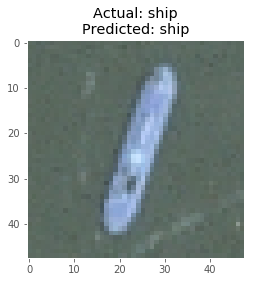

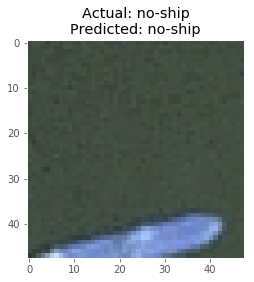

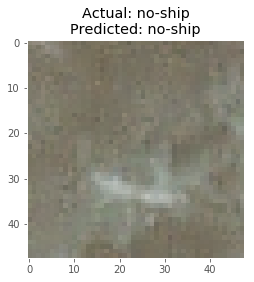

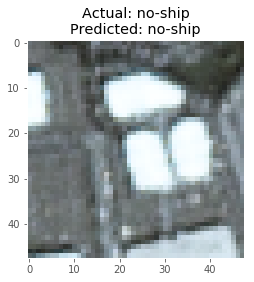

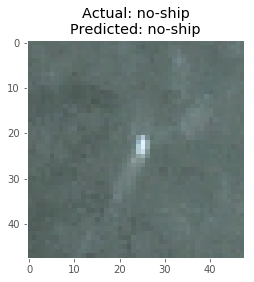

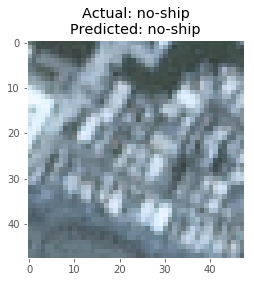

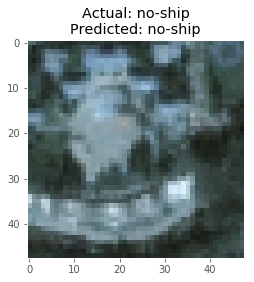

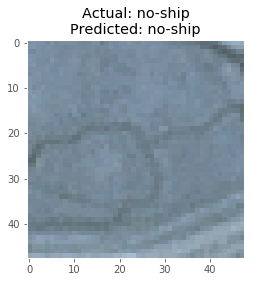

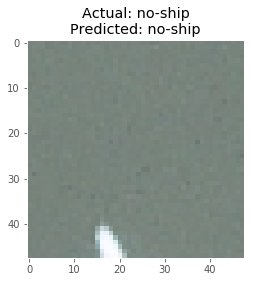

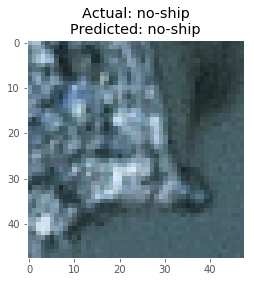

In [20]:
test_actual = np.argmax(test_labls,axis=1)
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape
rnd_idx = random.sample(range(0,400),10)
class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):

    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass


<Figure size 432x288 with 0 Axes>

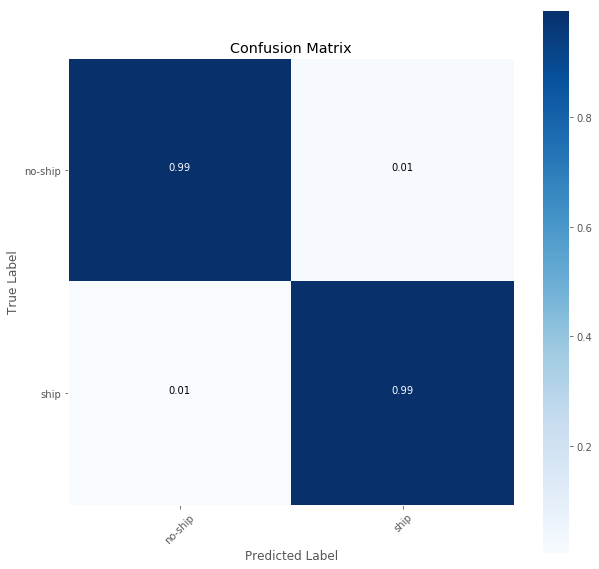

In [21]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

test_actual = np.argmax(test_labls,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

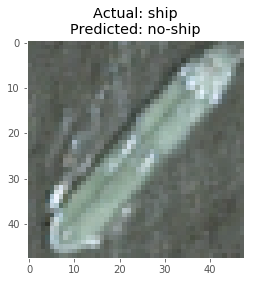

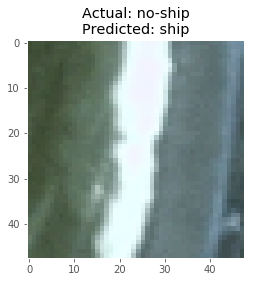

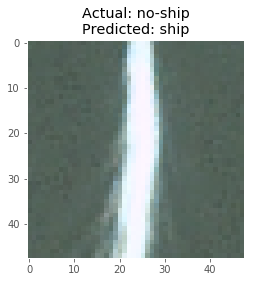

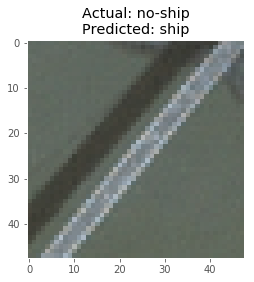

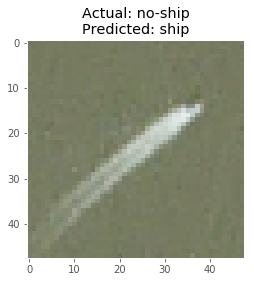

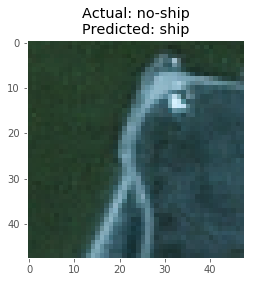

In [22]:
#class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
#class_labels

test_diff = np.where(test_actual!=test_pred)
test_diff = np.array(test_diff[0])

rnd_idx_diff = random.sample(range(0,np.size(test_diff)),6)
rnd_idx = test_diff[rnd_idx_diff]
for i,idx in enumerate(rnd_idx):
    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

**Saving the model**

In [24]:

model.save("ship-model-cnn.h5")
print("saved")

saved
